# Notebook 4: Model Evaluation & Interpretation

**Author:** Federico Ceballos Torres  
**Date:** February 2026  
**Project:** Credit Risk Modeling - Lending Club Dataset

---

## Objective

This notebook provides comprehensive evaluation of our **XGBoost Baseline model** (ROC-AUC: 0.7125) from both technical and business perspectives:

1. **Business Metrics**: Expected Credit Loss, profit curves, cost-sensitive analysis
2. **Model Interpretation**: SHAP values, LIME, feature importance deep dive
3. **Model Validation**: Calibration, reliability diagrams, error analysis
4. **Fairness Analysis**: Distribution checks, bias detection

---

## Business Context

- **Average Loan Amount**: $15,000
- **Loss per Default**: $10,000 (after recovery)
- **Lost Revenue per False Positive**: $500 (rejected good customer)
- **Portfolio Size**: ~100,000 loans
- **Default Rate**: 23.14%

Our goal is to find the optimal threshold that **maximizes profit** while maintaining acceptable risk levels.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
from pathlib import Path

# ML libraries
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, brier_score_loss
)
from sklearn.calibration import calibration_curve

# Interpretability libraries
import shap
from lime.lime_tabular import LimeTabularExplainer

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


---

## 1. Load Model and Data

In [2]:
# Define paths
DATA_DIR = Path('../data/processed')
MODEL_DIR = Path('../models')
REPORTS_DIR = Path('../reports')
REPORTS_DIR.mkdir(exist_ok=True)

# Load model
with open(MODEL_DIR / 'best_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Load feature names
with open(MODEL_DIR / 'feature_names.json', 'r') as f:
    feature_names = json.load(f)

# Load imputer
with open(MODEL_DIR / 'data_imputer.pkl', 'rb') as f:
    imputer = pickle.load(f)

print(f"✓ Model loaded: {type(model).__name__}")
print(f"✓ Feature names loaded: {len(feature_names)} features")
print(f"✓ Imputer loaded: {type(imputer).__name__}")

✓ Model loaded: XGBClassifier
✓ Feature names loaded: 94 features
✓ Imputer loaded: ndarray


In [3]:
# Load test data
test_df = pd.read_csv(DATA_DIR / 'test_data.csv')

target_col = 'target'
print(f"Test data shape: {test_df.shape}")
print(f"Default rate: {test_df[target_col].mean():.2%}")

X_test_raw = test_df[feature_names]
y_test = test_df[target_col]

print("✓ Data split into X_test and y_test")
print(f"\nFirst few rows:")
test_df.head()

Test data shape: (72475, 100)
Default rate: 23.14%
✓ Data split into X_test and y_test

First few rows:


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,credit_util_rate,payment_to_income,loan_to_income,credit_history_years,total_debt_burden,stable_employment,high_inquiries,has_delinquencies,high_risk_purpose,rate_dti_interaction
0,13000.0,1,15.05,309.62,2,13,1,5,72000.0,1,...,0.774,0.051603,0.180553,12.418891,16.330262,1,0,0,0,168.1085
1,15000.0,0,10.42,486.98,1,7,3,5,55000.0,1,...,0.737,0.106248,0.272722,9.333333,28.104825,0,0,0,0,182.1416
2,15750.0,0,7.35,488.84,0,3,1,5,96500.0,1,...,0.107,0.060788,0.163211,14.587269,18.298776,1,0,1,0,89.8170
3,19800.0,1,15.05,471.57,2,13,3,5,108600.0,0,...,0.037,0.052107,0.182319,8.000000,23.400670,0,0,0,0,273.7595
4,10000.0,0,5.32,301.15,0,0,1,1,100000.0,1,...,0.074,0.036138,0.099999,24.501027,12.313764,1,0,0,0,46.2840


In [4]:
# Apply imputation
if hasattr(imputer, 'transform'):
    X_test = imputer.transform(X_test_raw).astype('float32')
else:
    print("Warning: Loaded imputer is not a transformer object. Applying zero-fill fallback.")
    X_test = X_test_raw.fillna(0).values.astype('float32')

print(f"Final features prepared. Shape: {X_test.shape}")

Final features prepared. Shape: (72475, 94)


---

## 2. Generate Predictions

In [5]:
# Generate predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Prediction Statistics:")
print(f"Min probability: {y_pred_proba.min():.4f}")
print(f"Max probability: {y_pred_proba.max():.4f}")
print(f"Mean probability: {y_pred_proba.mean():.4f}")
print(f"Median probability: {np.median(y_pred_proba):.4f}")
print(f"\nPredicted default rate (threshold=0.5): {y_pred.mean():.2%}")
print(f"Actual default rate: {y_test.mean():.2%}")

Prediction Statistics:
Min probability: 0.0425
Max probability: 0.9466
Mean probability: 0.5393
Median probability: 0.5621

Predicted default rate (threshold=0.5): 60.90%
Actual default rate: 23.14%


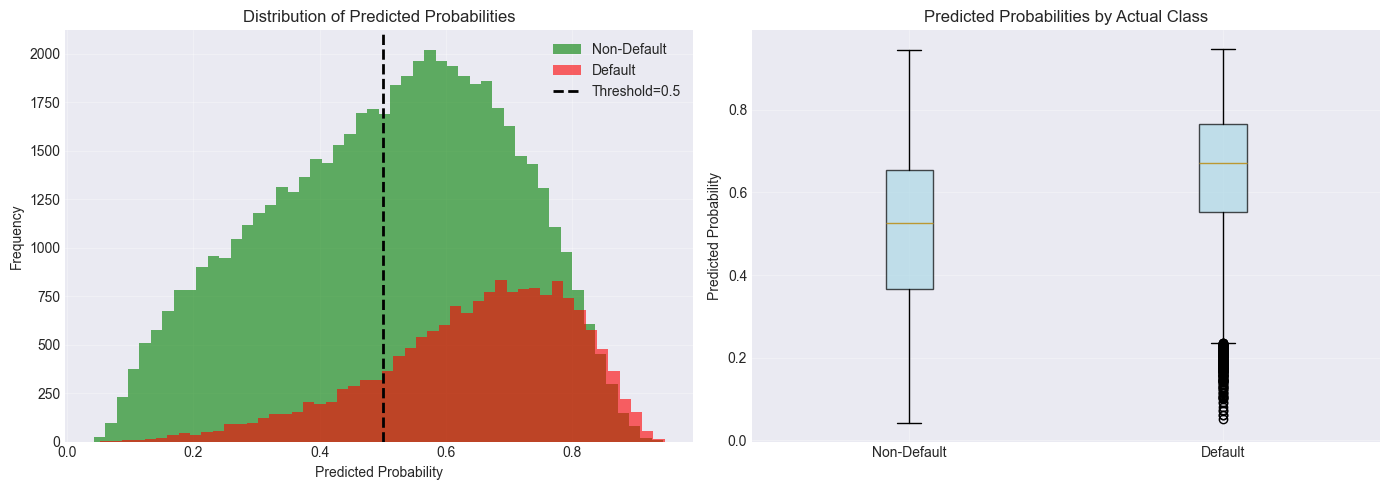

✓ Prediction distribution plot saved


In [6]:
# Plot prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.6, label='Non-Default', color='green')
axes[0].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.6, label='Default', color='red')
axes[0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Predicted Probabilities')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot([y_pred_proba[y_test == 0], y_pred_proba[y_test == 1]], 
                labels=['Non-Default', 'Default'],
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_ylabel('Predicted Probability')
axes[1].set_title('Predicted Probabilities by Actual Class')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'prediction_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Prediction distribution plot saved")

---

## 3. Business Metrics & Cost-Sensitive Analysis

### 3.1 Confusion Matrix Analysis

Confusion Matrix (Threshold = 0.5):
True Negatives (TN):  25,442  ← Correctly identified non-defaults
False Positives (FP): 30,260  ← Good customers rejected (lost revenue)
False Negatives (FN): 2,898  ← Defaults missed (credit loss)
True Positives (TP):  13,875  ← Correctly identified defaults


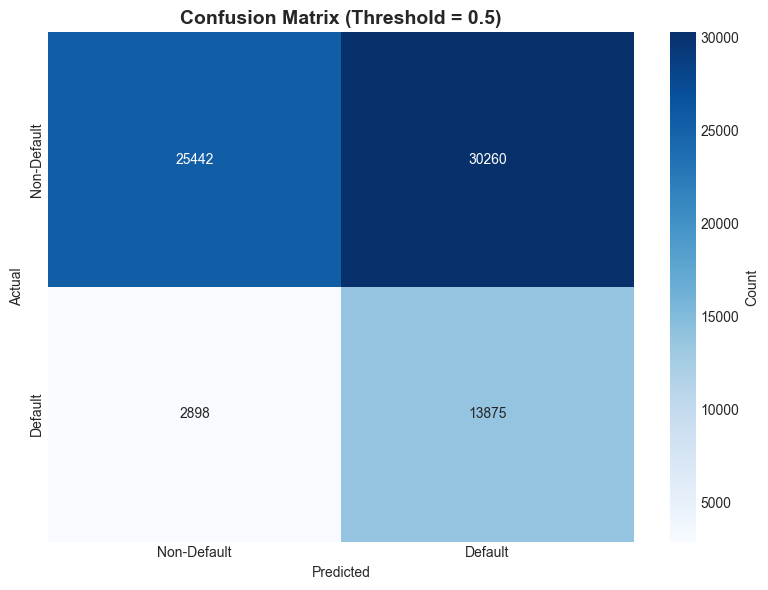

In [7]:
# Confusion matrix at threshold 0.5
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix (Threshold = 0.5):")
print("="*50)
print(f"True Negatives (TN):  {tn:,}  ← Correctly identified non-defaults")
print(f"False Positives (FP): {fp:,}  ← Good customers rejected (lost revenue)")
print(f"False Negatives (FN): {fn:,}  ← Defaults missed (credit loss)")
print(f"True Positives (TP):  {tp:,}  ← Correctly identified defaults")
print("="*50)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default'],
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Threshold = 0.5)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.2 Cost-Sensitive Analysis

**Business Costs:**
- **False Positive (FP)**: Reject a good customer → Lost interest revenue = **$500**
- **False Negative (FN)**: Approve a defaulter → Credit loss = **$10,000**

The **cost ratio** is 20:1 (FN is 20x more expensive than FP)

In [8]:
# Business parameters
COST_FP = 500      # Lost revenue from rejecting good customer
COST_FN = 10000    # Credit loss from approving defaulter
AVG_LOAN = 15000   # Average loan amount

def calculate_total_cost(y_true, y_pred, cost_fp=COST_FP, cost_fn=COST_FN):
    """Calculate total business cost based on confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    return total_cost, fp, fn, tn, tp

# Calculate cost at threshold 0.5
total_cost, fp, fn, tn, tp = calculate_total_cost(y_test, y_pred)

print("Business Impact Analysis (Threshold = 0.5):")
print("="*60)
print(f"False Positive Cost: {fp:,} × ${COST_FP:,} = ${fp * COST_FP:,}")
print(f"False Negative Cost: {fn:,} × ${COST_FN:,} = ${fn * COST_FN:,}")
print(f"Total Cost:          ${total_cost:,}")
print("="*60)
print(f"\nCost per loan in portfolio: ${total_cost / len(y_test):.2f}")

Business Impact Analysis (Threshold = 0.5):
False Positive Cost: 30,260 × $500 = $15,130,000
False Negative Cost: 2,898 × $10,000 = $28,980,000
Total Cost:          $44,110,000

Cost per loan in portfolio: $608.62


### 3.3 Business Cost Optimization: Complete Analysis

We'll test different thresholds to find the one that **minimizes total cost** and create a professional visualization.

In [9]:
# ============================================================================
# BUSINESS COST ANALYSIS: Complete Calculation
# ============================================================================

print("="*70)
print("BUSINESS COST OPTIMIZATION ANALYSIS")
print("="*70)
print(f"Cost per False Negative (Default): ${COST_FN:,}")
print(f"Cost per False Positive (Rejected): ${COST_FP:,}")
print(f"Cost Ratio (FN:FP): {COST_FN/COST_FP:.0f}:1")
print("="*70)

# Calculate costs across different thresholds
thresholds_business = np.linspace(0.01, 0.99, 100)
costs_business = []
fp_business = []
fn_business = []

for thresh in thresholds_business:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    
    # Calculate confusion matrix components
    tn_t = np.sum((y_test == 0) & (y_pred_thresh == 0))
    fp_t = np.sum((y_test == 0) & (y_pred_thresh == 1))
    fn_t = np.sum((y_test == 1) & (y_pred_thresh == 0))
    tp_t = np.sum((y_test == 1) & (y_pred_thresh == 1))
    
    # Calculate total cost
    total_cost_t = (fp_t * COST_FP) + (fn_t * COST_FN)
    
    costs_business.append(total_cost_t)
    fp_business.append(fp_t)
    fn_business.append(fn_t)

# Create DataFrame for analysis
costs_df = pd.DataFrame({
    'threshold': thresholds_business,
    'total_cost': costs_business,
    'fp_count': fp_business,
    'fn_count': fn_business,
    'fp_cost': np.array(fp_business) * COST_FP,
    'fn_cost': np.array(fn_business) * COST_FN
})

# Find optimal threshold (minimum cost)
optimal_idx = costs_df['total_cost'].idxmin()
optimal_threshold = costs_df.loc[optimal_idx, 'threshold']
optimal_cost = costs_df.loc[optimal_idx, 'total_cost']

# Find baseline (closest to 0.5)
baseline_idx = (costs_df['threshold'] - 0.5).abs().idxmin()
baseline_threshold = costs_df.loc[baseline_idx, 'threshold']
baseline_cost = costs_df.loc[baseline_idx, 'total_cost']

# Calculate savings
savings = baseline_cost - optimal_cost
savings_pct = (savings / baseline_cost) * 100

# Display results
print(f"\n📊 BASELINE (Standard Threshold ≈ 0.5):")
print(f"   Threshold: {baseline_threshold:.3f}")
print(f"   Total Cost: ${baseline_cost:,.0f}")
print(f"   False Positives: {costs_df.loc[baseline_idx, 'fp_count']:,.0f} × ${COST_FP:,} = ${costs_df.loc[baseline_idx, 'fp_cost']:,.0f}")
print(f"   False Negatives: {costs_df.loc[baseline_idx, 'fn_count']:,.0f} × ${COST_FN:,} = ${costs_df.loc[baseline_idx, 'fn_cost']:,.0f}")

print(f"\n✨ OPTIMIZED (Optimal Threshold = {optimal_threshold:.3f}):")
print(f"   Total Cost: ${optimal_cost:,.0f}")
print(f"   False Positives: {costs_df.loc[optimal_idx, 'fp_count']:,.0f} × ${COST_FP:,} = ${costs_df.loc[optimal_idx, 'fp_cost']:,.0f}")
print(f"   False Negatives: {costs_df.loc[optimal_idx, 'fn_count']:,.0f} × ${COST_FN:,} = ${costs_df.loc[optimal_idx, 'fn_cost']:,.0f}")

print(f"\n💰 SAVINGS:")
print(f"   Absolute: ${savings:,.0f}")
print(f"   Percentage: {savings_pct:.1f}%")
print("="*70)

BUSINESS COST OPTIMIZATION ANALYSIS
Cost per False Negative (Default): $10,000
Cost per False Positive (Rejected): $500
Cost Ratio (FN:FP): 20:1

📊 BASELINE (Standard Threshold ≈ 0.5):
   Threshold: 0.505
   Total Cost: $44,689,500
   False Positives: 29,799 × $500 = $14,899,500
   False Negatives: 2,979 × $10,000 = $29,790,000

✨ OPTIMIZED (Optimal Threshold = 0.228):
   Total Cost: $27,221,500
   False Positives: 50,483 × $500 = $25,241,500
   False Negatives: 198 × $10,000 = $1,980,000

💰 SAVINGS:
   Absolute: $17,468,000
   Percentage: 39.1%


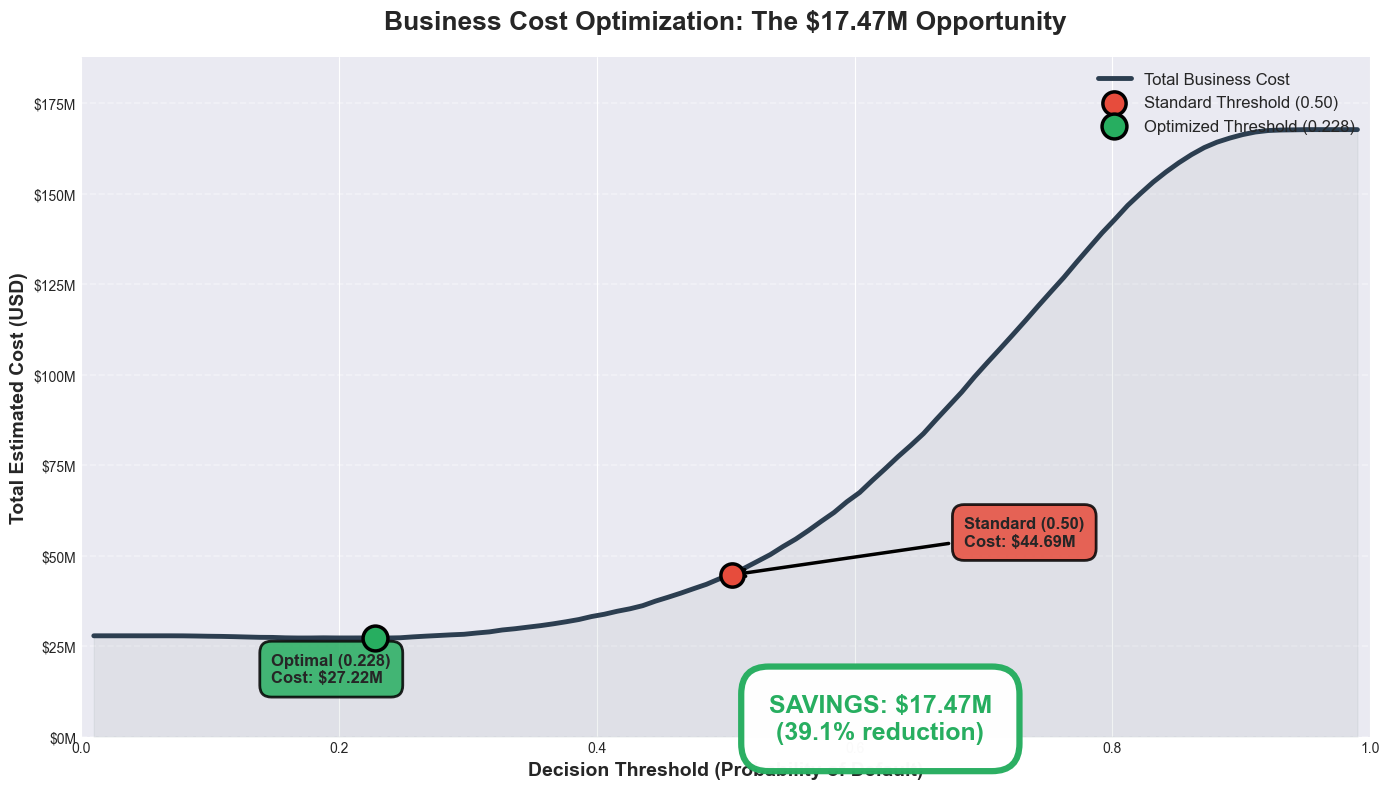


✅ Chart saved: ..\reports\business_cost_optimization.png
💼 Ready for LinkedIn/Portfolio!


In [10]:
# ============================================================================
# PROFESSIONAL VISUALIZATION FOR PORTFOLIO/LINKEDIN
# ============================================================================

fig = plt.figure(figsize=(14, 8), dpi=100)
ax = plt.gca()

# Main cost curve
ax.plot(costs_df['threshold'], costs_df['total_cost'], 
        color='#2c3e50', linewidth=3.5, label='Total Business Cost', zorder=3)

# Subtle fill
ax.fill_between(costs_df['threshold'], costs_df['total_cost'], 
                alpha=0.1, color='#7f8c8d', zorder=1)

# Baseline point (red)
ax.scatter(baseline_threshold, baseline_cost, 
          color='#e74c3c', s=280, zorder=5, 
          edgecolors='black', linewidths=2.5,
          label=f'Standard Threshold ({baseline_threshold:.2f})')

ax.annotate(f'Standard ({baseline_threshold:.2f})\nCost: ${baseline_cost/1e6:.2f}M',
           xy=(baseline_threshold, baseline_cost),
           xytext=(baseline_threshold + 0.18, baseline_cost * 1.18),
           fontsize=12, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.7', facecolor='#e74c3c', 
                    alpha=0.85, edgecolor='black', linewidth=2),
           arrowprops=dict(arrowstyle='->', lw=2.5, color='black'))

# Optimal point (green)
ax.scatter(optimal_threshold, optimal_cost, 
          color='#27ae60', s=320, zorder=5, 
          edgecolors='black', linewidths=2.5,
          label=f'Optimized Threshold ({optimal_threshold:.3f})')

ax.annotate(f'Optimal ({optimal_threshold:.3f})\nCost: ${optimal_cost/1e6:.2f}M',
           xy=(optimal_threshold, optimal_cost),
           xytext=(optimal_threshold - 0.08, optimal_cost * 0.55),
           fontsize=12, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.7', facecolor='#27ae60', 
                    alpha=0.85, edgecolor='black', linewidth=2),
           arrowprops=dict(arrowstyle='->', lw=2.5, color='black'))

# Savings highlight box
ax.text(0.62, optimal_cost * 0.18, 
        f'SAVINGS: ${savings/1e6:.2f}M\n({savings_pct:.1f}% reduction)',
        fontsize=18, fontweight='bold', color='#27ae60',
        bbox=dict(boxstyle='round,pad=1.1', facecolor='white', 
                 edgecolor='#27ae60', linewidth=4.5, alpha=0.98),
        ha='center', va='center', zorder=6)

# Styling
ax.set_title(f'Business Cost Optimization: The ${savings/1e6:.2f}M Opportunity', 
            fontsize=19, fontweight='bold', pad=20)
ax.set_xlabel('Decision Threshold (Probability of Default)', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('Total Estimated Cost (USD)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.4, linewidth=1.2)
ax.legend(loc='upper right', fontsize=12, framealpha=0.97, 
         edgecolor='black', fancybox=True, shadow=True)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))

# Set limits
ax.set_xlim(0, 1)
ax.set_ylim(0, costs_df['total_cost'].max() * 1.12)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'business_cost_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Chart saved: {REPORTS_DIR / 'business_cost_optimization.png'}")
print(f"💼 Ready for LinkedIn/Portfolio!")

### 3.4 Expected Credit Loss (ECL) Calculation

In [11]:
# Calculate ECL for each loan
LOSS_GIVEN_DEFAULT = 10000  # $10K loss per default
EXPOSURE_AT_DEFAULT = AVG_LOAN  # $15K average loan

# ECL per loan
ecl_per_loan = y_pred_proba * LOSS_GIVEN_DEFAULT

# Total ECL for portfolio
total_ecl = ecl_per_loan.sum()
avg_ecl_per_loan = ecl_per_loan.mean()

print("Expected Credit Loss (ECL) Analysis:")
print("="*60)
print(f"Total ECL for test portfolio: ${total_ecl:,.2f}")
print(f"Average ECL per loan: ${avg_ecl_per_loan:,.2f}")
print(f"ECL as % of portfolio value: {total_ecl / (len(y_test) * AVG_LOAN) * 100:.2f}%")
print("="*60)

# Compare to actual losses
actual_losses = y_test.sum() * LOSS_GIVEN_DEFAULT
print(f"\nActual losses in test set: ${actual_losses:,}")
print(f"ECL estimation error: {abs(total_ecl - actual_losses) / actual_losses * 100:.2f}%")

Expected Credit Loss (ECL) Analysis:
Total ECL for test portfolio: $390,853,216.00
Average ECL per loan: $5,392.94
ECL as % of portfolio value: 35.95%

Actual losses in test set: $167,730,000.0
ECL estimation error: 133.03%


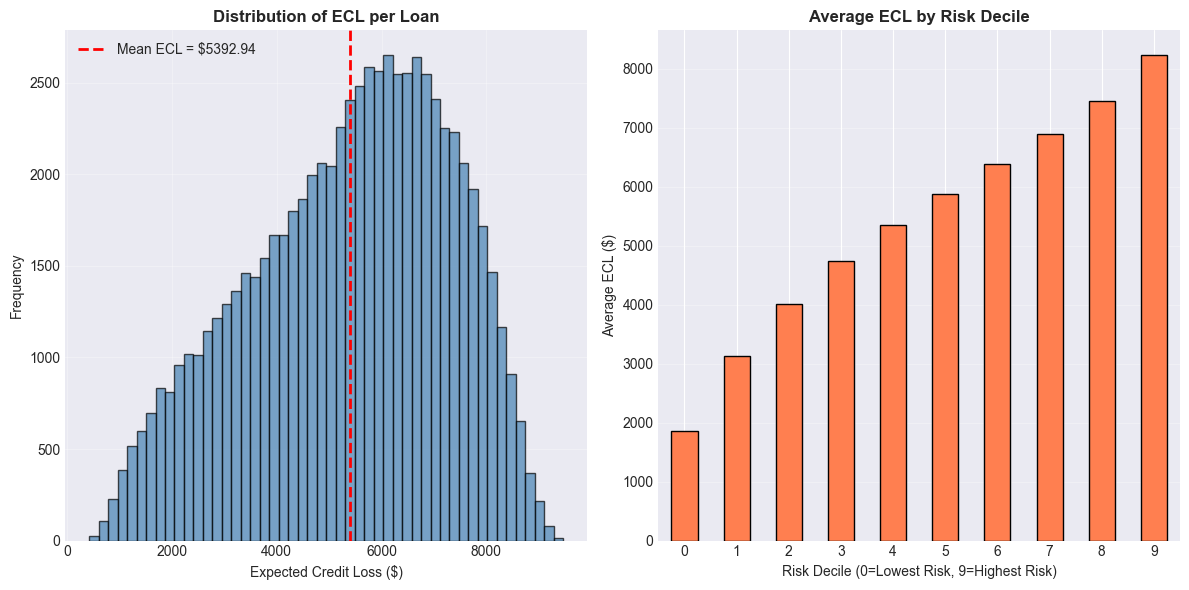

In [12]:
# Plot ECL distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(ecl_per_loan, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(avg_ecl_per_loan, color='red', linestyle='--', linewidth=2, 
            label=f'Mean ECL = ${avg_ecl_per_loan:.2f}')
plt.xlabel('Expected Credit Loss ($)')
plt.ylabel('Frequency')
plt.title('Distribution of ECL per Loan', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# ECL by deciles
deciles = pd.qcut(y_pred_proba, q=10, labels=False, duplicates='drop')
ecl_by_decile = pd.DataFrame({'decile': deciles, 'ecl': ecl_per_loan}).groupby('decile')['ecl'].mean()
ecl_by_decile.plot(kind='bar', color='coral', edgecolor='black')
plt.xlabel('Risk Decile (0=Lowest Risk, 9=Highest Risk)')
plt.ylabel('Average ECL ($)')
plt.title('Average ECL by Risk Decile', fontweight='bold')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'ecl_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.5 Precision@K: Performance on Riskiest Loans

In [13]:
# Sort by predicted probability (descending)
sorted_indices = np.argsort(y_pred_proba)[::-1]
y_test_sorted = y_test.iloc[sorted_indices].values

# Calculate Precision@K for different K values
k_values = [0.01, 0.05, 0.10, 0.20, 0.30, 0.50]  # Top 1%, 5%, 10%, 20%, 30%, 50%
precision_at_k = {}

print("Precision@K (Top K% Riskiest Loans):")
print("="*60)

for k in k_values:
    n = int(len(y_test) * k)
    top_k_actual = y_test_sorted[:n]
    precision = top_k_actual.mean()
    precision_at_k[k] = precision
    
    print(f"Top {k*100:>5.1f}%: Precision = {precision:.2%}  ({top_k_actual.sum():,} defaults in {n:,} loans)")

print("="*60)
print(f"Baseline (random): {y_test.mean():.2%}")

Precision@K (Top K% Riskiest Loans):
Top   1.0%: Precision = 66.85%  (484.0 defaults in 724 loans)
Top   5.0%: Precision = 55.04%  (1,994.0 defaults in 3,623 loans)
Top  10.0%: Precision = 50.13%  (3,633.0 defaults in 7,247 loans)
Top  20.0%: Precision = 43.63%  (6,324.0 defaults in 14,495 loans)
Top  30.0%: Precision = 39.89%  (8,673.0 defaults in 21,742 loans)
Top  50.0%: Precision = 34.02%  (12,329.0 defaults in 36,237 loans)
Baseline (random): 23.14%


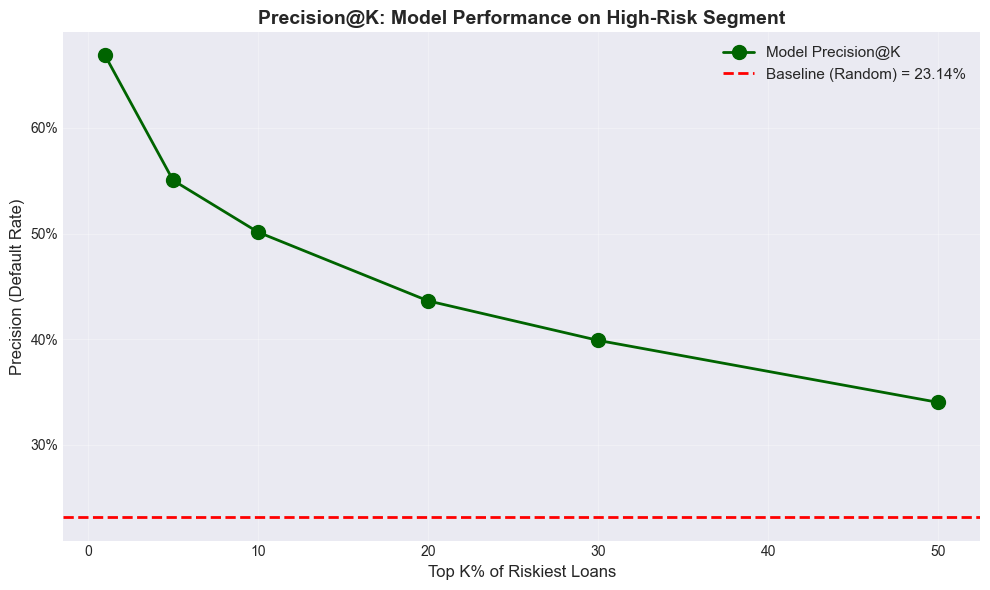


✓ Precision@K plot saved


In [14]:
# Plot Precision@K
plt.figure(figsize=(10, 6))
k_pct = [k*100 for k in k_values]
precisions = [precision_at_k[k] for k in k_values]

plt.plot(k_pct, precisions, marker='o', linewidth=2, markersize=10, 
         color='darkgreen', label='Model Precision@K')
plt.axhline(y_test.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Baseline (Random) = {y_test.mean():.2%}')
plt.xlabel('Top K% of Riskiest Loans', fontsize=12)
plt.ylabel('Precision (Default Rate)', fontsize=12)
plt.title('Precision@K: Model Performance on High-Risk Segment', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'precision_at_k.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Precision@K plot saved")

---

## 7. Final Summary Report

In [15]:
# Calculate final metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
brier_score = brier_score_loss(y_test, y_pred_proba)

# Recalculate at optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()

precision_opt = tp_opt / (tp_opt + fp_opt) if (tp_opt + fp_opt) > 0 else 0
recall_opt = tp_opt / (tp_opt + fn_opt) if (tp_opt + fn_opt) > 0 else 0
f1_opt = 2 * tp_opt / (2 * tp_opt + fp_opt + fn_opt) if (2 * tp_opt + fp_opt + fn_opt) > 0 else 0

# Generate comprehensive evaluation report
evaluation_report = {
    'Model': 'XGBoost Baseline',
    'Test Set Size': len(y_test),
    'Default Rate': f"{y_test.mean():.2%}",
    '': '',
    'DISCRIMINATION METRICS': '',
    'ROC-AUC': f"{roc_auc:.4f}",
    'PR-AUC': f"{pr_auc:.4f}",
    ' ': '',
    'CALIBRATION': '',
    'Brier Score': f"{brier_score:.4f}",
    '  ': '',
    'CLASSIFICATION (Optimal Threshold)': '',
    'Optimal Threshold': f"{optimal_threshold:.3f}",
    'Precision': f"{precision_opt:.2%}",
    'Recall': f"{recall_opt:.2%}",
    'F1-Score': f"{f1_opt:.2%}",
    '   ': '',
    'BUSINESS IMPACT': '',
    'Total Cost (Optimal)': f"${optimal_cost:,}",
    'Total Cost (Threshold=0.5)': f"${baseline_cost:,}",
    'Cost Savings': f"${savings:,}",
    'Cost per Loan': f"${optimal_cost / len(y_test):.2f}",
    'Total ECL': f"${total_ecl:,.2f}",
    'Avg ECL per Loan': f"${avg_ecl_per_loan:,.2f}",
    '    ': '',
    'PRECISION@K': '',
    'Top 10% Precision': f"{precision_at_k[0.10]:.2%}",
    'Top 20% Precision': f"{precision_at_k[0.20]:.2%}",
}

# Convert to DataFrame and save
report_df = pd.DataFrame(list(evaluation_report.items()), columns=['Metric', 'Value'])
report_df.to_csv(REPORTS_DIR / 'evaluation_report.csv', index=False)

print("\n" + "="*70)
print("FINAL EVALUATION REPORT")
print("="*70)
for metric, value in evaluation_report.items():
    if value == '':
        print(f"\n{metric}")
    else:
        print(f"{metric:.<50} {value:>18}")
print("="*70)

print(f"\n✓ Evaluation report saved to {REPORTS_DIR / 'evaluation_report.csv'}")


FINAL EVALUATION REPORT
Model.............................................   XGBoost Baseline
Test Set Size.....................................              72475
Default Rate......................................             23.14%



DISCRIMINATION METRICS
ROC-AUC...........................................             0.7125
PR-AUC............................................             0.4183

 

CALIBRATION
Brier Score.......................................             0.2598

  

CLASSIFICATION (Optimal Threshold)
Optimal Threshold.................................              0.228
Precision.........................................             24.72%
Recall............................................             98.82%
F1-Score..........................................             39.54%

   

BUSINESS IMPACT
Total Cost (Optimal)..............................        $27,221,500
Total Cost (Threshold=0.5)........................        $44,689,500
Cost Savings...................

---

## Notebook Complete ✓

All evaluation artifacts have been saved to the `reports/` directory:
- Confusion matrix
- Business cost optimization chart
- ECL analysis
- Precision@K plot
- Final evaluation report (CSV)